Bias and variance of SVMs
=========================

*Fraida Fund*

In this notebook, we will explore the bias and variance of SVM models, and see how we can tune this tradeoff.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

from tqdm import tqdm

from sklearn.datasets import make_blobs

### Regularization level

Suppose we want to train a model to classify two “blobs” of data.

In [2]:
n_repeat = 100
n_test = 500
n_train = 100
sigma= 0.8
cluster_centers = np.array([[-1,1],[2,2]])

In [3]:
y_predict = np.zeros((n_test, n_repeat, 2))

In [4]:
x_test, y_test = make_blobs(n_samples=n_test, centers=cluster_centers,
                  random_state=0, cluster_std=sigma)

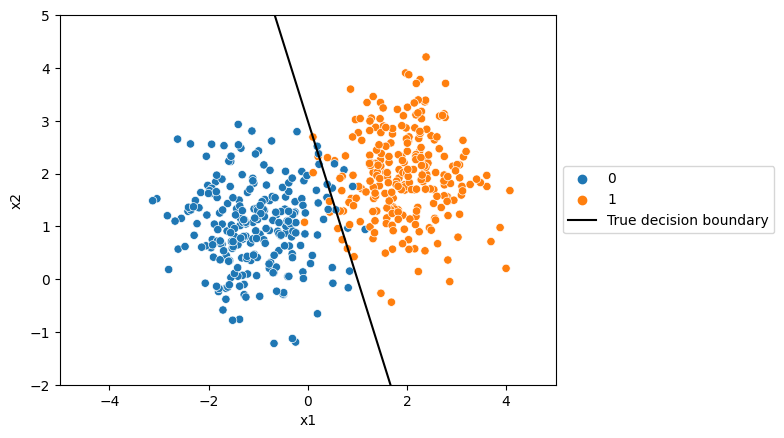

In [5]:
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test);

plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim(-5,5);
plt.ylim(-2,5);

# get the true decision boundary
mid = [cluster_centers[:,0].mean(), cluster_centers[:,1].mean()]
slp = -1.0/((cluster_centers[1,1]-cluster_centers[0,1])/(cluster_centers[1,0]-cluster_centers[0,0]))
b = mid[1]-slp*mid[0]
x_true = np.arange(-5,5)
y_true = slp*x_true + b
sns.lineplot(x=x_true, y=y_true, color='black', label="True decision boundary")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

Which will have greater bias, and which will have greater variance?

-   **Model A**: Linear SVM with $C=0.01$

-   **Model B**: Linear SVM with $C=100$

Note: here is $C$ in the SVM problem:

$$
\begin{aligned}
\operatorname*{minimize}_{\mathbf{w}, \mathbf{\epsilon}} \quad & \frac{1}{2} \sum_{j=1}^p w_j^2  + C \sum_{i=1}^n \epsilon_i  \\
\text{subject to} \quad & y_i(w_0 + \sum_{j=1}^p w_j x_{ij}) \geq 1-\epsilon_i, \quad \forall i \\
& \epsilon_i \geq 0, \quad \forall i
\end{aligned}
$$

The greater the value of $C$, the more heavily the “margin violators” penalize the overall objective function. Therefore,

-   If $C$ is large, the margin must be narrow (with few “margin violators”).
-   If $C$ is small, the margin may be wider (with more “margin violators”).

Simulation iteration: 100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


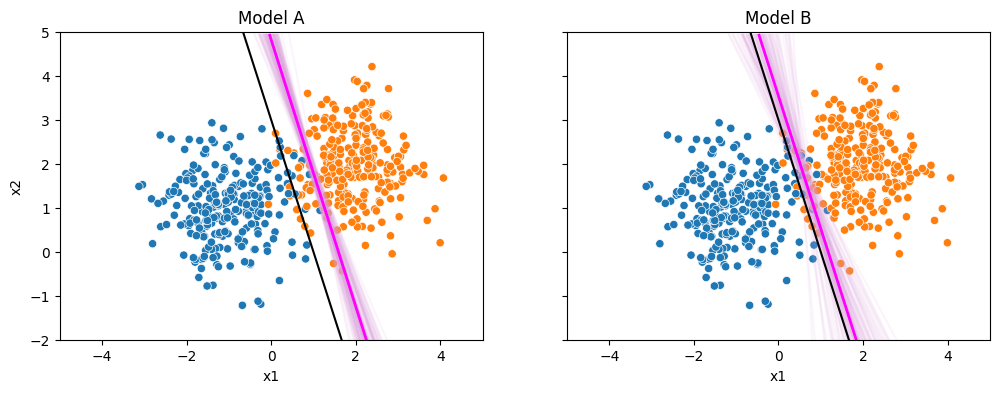

In [6]:
Z_sim = np.zeros((40000, n_repeat, 2))

fig = plt.figure(figsize=(12,4))
ax_a, ax_b = fig.subplots(1, 2, sharex=True, sharey=True)

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in tqdm(range(n_repeat), total=n_repeat, desc="Simulation iteration"):

  # train both models on newly generated training data
  X, y = make_blobs(n_samples=n_test, centers=cluster_centers,
                  cluster_std=sigma)

  clf_a = SVC(kernel='linear', C=0.01).fit(X, y)
  clf_b = SVC(kernel='linear', C=100.0).fit(X, y)

  y_predict[:, i, 0] = clf_a.predict(x_test)
  y_predict[:, i, 1] = clf_b.predict(x_test)


  xx, yy = np.meshgrid(np.arange(-5, 5, .05),
                      np.arange(-5, 5, .05))

  Z = clf_a.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 0] = Z
  Z = Z.reshape(xx.shape)
  ax_a.contour(xx, yy, Z, levels=[0.5], alpha=0.1, colors='plum');

  plt.xlim(-5,5);
  plt.ylim(-2,5);

  Z = clf_b.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 1] = Z
  Z = Z.reshape(xx.shape)
  ax_b.contour(xx, yy, Z, levels=[0.5], alpha=0.1, colors='plum');

  plt.xlim(-5,5);
  plt.ylim(-2,5);


cs_a = ax_a.contour(xx, yy, Z_sim[:,:,0].mean(axis=1).reshape(200,200), levels=[0.5], colors='magenta', linewidths=2);
cs_b = ax_b.contour(xx, yy, Z_sim[:,:,1].mean(axis=1).reshape(200,200), levels=[0.5], colors='magenta', linewidths=2);

# plot data
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test, ax=ax_a, legend=False);
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test, ax=ax_b, legend=False);

sns.lineplot(x=x_true, y=y_true, color='black', ax=ax_a)
sns.lineplot(x=x_true, y=y_true, color='black', ax=ax_b)


ax_a.set_title("Model A");
ax_b.set_title("Model B");

ax_a.set_ylabel("x2");
ax_a.set_xlabel("x1");
ax_b.set_xlabel("x1");

### Kernels

In [7]:
def generate_polynomial_classifier_data(n=100, xrange=[-1,1], coefs=[1,0.5,0,2], sigma=0.5):
  x = np.random.uniform(xrange[0], xrange[1], size=(n, 2))
  ysep = np.polynomial.polynomial.polyval(x[:,0],coefs)
  y = (x[:,1]>ysep).astype(int)
  x[:,0] = x[:,0] + sigma * np.random.randn(n)
  x[:,1] = x[:,1] + sigma * np.random.randn(n)
  return x, y

In [8]:
n_repeat = 100
n_test = 500
n_train = 1000
sigma= 0.3
coefs=np.array([0.3, 1, -1.5, -2])
xrange=[-1,1]

In [9]:
y_predict = np.zeros((n_test, n_repeat, 2))

In [10]:
# generate test data once
x_test, y_test = generate_polynomial_classifier_data(n=n_test, xrange=xrange, coefs=coefs, sigma=sigma)

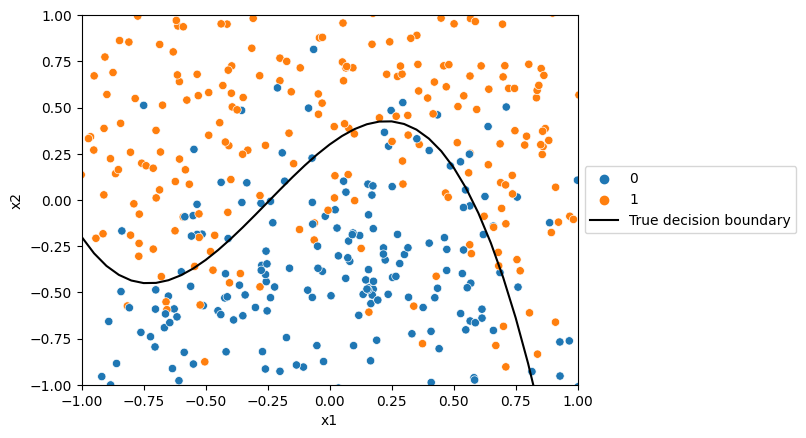

In [11]:
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test);

plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim((xrange[0], xrange[1]));
plt.ylim((xrange[0], xrange[1]));

# Plot true function
xtrue = np.arange(-1.5, 1.5, .05)
ytrue = np.polynomial.polynomial.polyval(xtrue,coefs)
sns.lineplot(x=xtrue, y=ytrue, color='black', label='True decision boundary');


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

Suppose we want to train a model to classify data that is separated by a polynomial boundary.

Which will have greater bias, and which will have greater variance?

-   **Model A**: SVM with linear kernel, $C = 1$

-   **Model B**: SVM with RBF kernel, $C = 1$

Simulation iteration: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


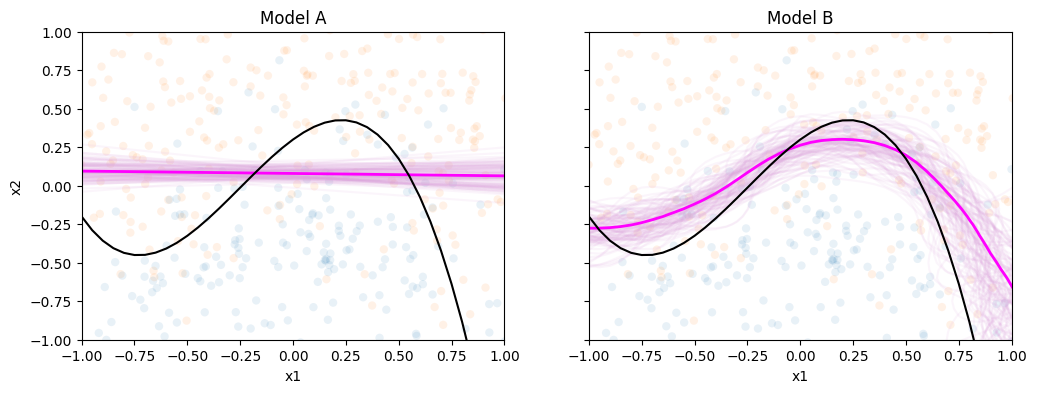

In [12]:
Z_sim = np.zeros((3600, n_repeat, 2))

fig = plt.figure(figsize=(12,4))
ax_a, ax_b = fig.subplots(1, 2, sharex=True, sharey=True)

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in tqdm(range(n_repeat), total=n_repeat, desc="Simulation iteration"):

  # train both models on newly generated training data
  X, y = generate_polynomial_classifier_data(n=n_train, xrange=xrange, coefs=coefs, sigma=sigma)

  clf_a = SVC(kernel='linear', C=1).fit(X, y)
  clf_b = SVC(kernel='rbf', gamma=10,  C=1).fit(X, y)

  y_predict[:, i, 0] = clf_a.predict(x_test)
  y_predict[:, i, 1] = clf_b.predict(x_test)


  xx, yy = np.meshgrid(np.arange(-1.5, 1.5, .05),
                      np.arange(-1.5, 1.5, .05))

  Z = clf_a.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 0] = Z
  Z = Z.reshape(xx.shape)
  ax_a.contour(xx, yy, Z, levels=[0.5], alpha=0.1, colors='plum');
  plt.xlim((xrange[0], xrange[1]));
  plt.ylim((xrange[0], xrange[1]));

  Z = clf_b.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 1] = Z
  Z = Z.reshape(xx.shape)
  ax_b.contour(xx, yy, Z, levels=[0.5], alpha=0.1, colors='plum');
  plt.xlim((xrange[0], xrange[1]));
  plt.ylim((xrange[0], xrange[1]));


cs_a = ax_a.contour(xx, yy, Z_sim[:,:,0].mean(axis=1).reshape(60,60), levels=[0.5], colors='magenta', linewidths=2);
cs_b = ax_b.contour(xx, yy, Z_sim[:,:,1].mean(axis=1).reshape(60,60), levels=[0.5], colors='magenta', linewidths=2);


# Plot true function
xtrue = np.arange(-1.5, 1.5, .05)
ytrue = np.polynomial.polynomial.polyval(xtrue,coefs)
sns.lineplot(x=xtrue, y=ytrue, color='black', ax=ax_a);
sns.lineplot(x=xtrue, y=ytrue, color='black', ax=ax_b);

sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test, ax=ax_a, legend=False, alpha=0.1);
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test, ax=ax_b, legend=False, alpha=0.1);

ax_a.set_title("Model A");
ax_b.set_title("Model B");

ax_a.set_ylabel("x2");
ax_a.set_xlabel("x1");
ax_b.set_xlabel("x1");

### RBF parameter

Recall that the RBF kernel is defined as

$$K(x,z) = \exp(-\frac{\|x-z\|^2_2}{\sigma^2})$$

where $\sigma$ is the bandwidth, or equivalently, using a $\gamma$ parameter,

$$K(x, z) = \exp(-\gamma \| x - z \|^2_2 )$$

For example, here is the RBF kernel centered on a single point, computed over the entire feature space, with two different values of $\gamma$:

In [13]:
from sklearn.metrics.pairwise import rbf_kernel

test_point = np.random.uniform(0,1,size=2)
xx, yy = np.meshgrid(np.arange(0 ,5, .05), np.arange(0, 5, .05))

gamma_a=0.05
gamma_b=5
Z_a = rbf_kernel(np.c_[xx.ravel(), yy.ravel()], test_point.reshape(1, -1), gamma=gamma_a)
Z_b = rbf_kernel(np.c_[xx.ravel(), yy.ravel()], test_point.reshape(1, -1), gamma=gamma_b)

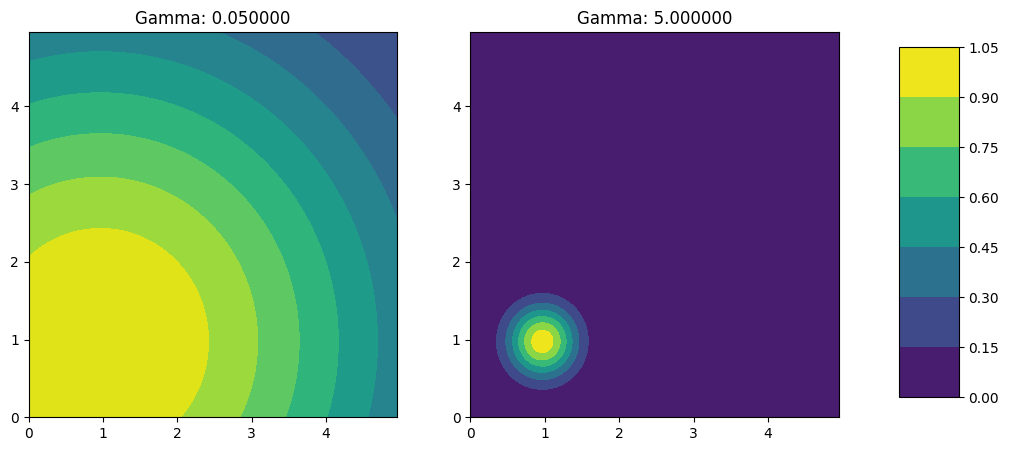

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

plt.scatter(x=test_point[0], y=test_point[1])
cs = plt.contourf(xx, yy, Z_a.reshape(xx.shape), vmin=0, vmax=1);
plt.title("Gamma: %f" % gamma_a);

plt.subplot(1,2,2)


plt.scatter(x=test_point[0], y=test_point[1])
cs = plt.contourf(xx, yy, Z_b.reshape(xx.shape), vmin=0, vmax=1);
plt.title("Gamma: %f" % gamma_b);

plt.subplots_adjust(right=0.8);
cbar_ax = plt.axes([0.85, 0.15, 0.05, 0.7]);
plt.colorbar(cax=cbar_ax);

We can see that when the kernel bandwidth is large ($\gamma$ is small), the influence of each point extends much farther in the feature space than if the kernel bandwidth is small ($\gamma$ is large).

Suppose we want to train a model to classify data that is separated by a polynomial boundary.

Which will have greater bias, and which will have greater variance?

-   **Model A**: SVM with RBF kernel and $\gamma=0.05$

-   **Model B**: SVM with RBF kernel and $\gamma=5$

In [15]:
n_repeat = 100
n_test = 500
n_train = 100
sigma= 0.3
coefs=np.array([0.3, 1, -1.5, -2])
xrange=[-1,1]

In [16]:
y_predict = np.zeros((n_test, n_repeat, 2))

In [17]:
# generate test data once
x_test, y_test = generate_polynomial_classifier_data(n=n_test, xrange=xrange, coefs=coefs, sigma=sigma)

Simulation iteration: 100%|██████████| 100/100 [00:03<00:00, 32.88it/s]


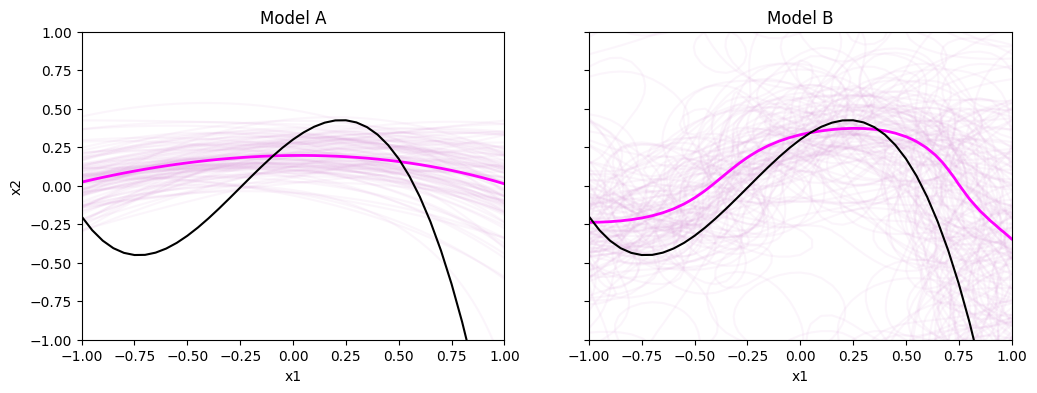

In [18]:
Z_sim = np.zeros((3600, n_repeat, 2))

fig = plt.figure(figsize=(12,4))
ax_a, ax_b = fig.subplots(1, 2, sharex=True, sharey=True)

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in tqdm(range(n_repeat), total=n_repeat, desc="Simulation iteration"):

  # train both models on newly generated training data
  X, y = generate_polynomial_classifier_data(n=n_train, xrange=xrange, coefs=coefs, sigma=sigma)

  clf_a = SVC(kernel='rbf', gamma=0.05, C=10).fit(X, y)
  clf_b = SVC(kernel='rbf', gamma=5, C=10).fit(X, y)

  y_predict[:, i, 0] = clf_a.predict(x_test)
  y_predict[:, i, 1] = clf_b.predict(x_test)


  xx, yy = np.meshgrid(np.arange(-1.5, 1.5, .05),
                      np.arange(-1.5, 1.5, .05))

  Z = clf_a.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 0] = Z
  Z = Z.reshape(xx.shape)
  ax_a.contour(xx, yy, Z, levels=[0.5], alpha=0.1, colors='plum');
  plt.xlim((xrange[0], xrange[1]));
  plt.ylim((xrange[0], xrange[1]));

  Z = clf_b.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 1] = Z
  Z = Z.reshape(xx.shape)
  ax_b.contour(xx, yy, Z, levels=[0.5], alpha=0.1, colors='plum');
  plt.xlim((xrange[0], xrange[1]));
  plt.ylim((xrange[0], xrange[1]));


cs_a = ax_a.contour(xx, yy, Z_sim[:,:,0].mean(axis=1).reshape(60,60), levels=[0.5], colors='magenta', linewidths=2);
cs_b = ax_b.contour(xx, yy, Z_sim[:,:,1].mean(axis=1).reshape(60,60), levels=[0.5], colors='magenta', linewidths=2);


# Plot true function
xtrue = np.arange(-1.5, 1.5, .05)
ytrue = np.polynomial.polynomial.polyval(xtrue,coefs)
sns.lineplot(x=xtrue, y=ytrue, color='black', ax=ax_a);
sns.lineplot(x=xtrue, y=ytrue, color='black', ax=ax_b);

#sns.scatterplot(x_test[:,0], x_test[:,1], y_test, ax=ax_a, legend=False, alpha=0.1);
#sns.scatterplot(x_test[:,0], x_test[:,1], y_test, ax=ax_b, legend=False, alpha=0.1);

ax_a.set_title("Model A");
ax_b.set_title("Model B");

ax_a.set_ylabel("x2");
ax_a.set_xlabel("x1");
ax_b.set_xlabel("x1");

Hyperparameter search
---------------------

For models with a single hyperparameter controlling bias-variance (for example: $k$ in $k$ nearest neighbors), we used sklearns's `KFoldCV` or `validation_curve` to test a range of values for the hyperparameter, and to select the best one.

When we have *multiple* hyperparameters to tune, we can use `GridSearchCV` to select the best *combination* of them.

For example, we just saw saw three ways to tune the bias-variance of an SVM classifier:

-   Changing the kernel
-   Changing $C$
-   For an RBF kernel, changing $\gamma$

To get the best performance from an SVM classifier, we need to find the best *combination* of these hyperparameters. This notebook shows how to use `GridSearchCV` to tune an SVM classifier.

We will work with a subset of the MNIST handwritten digits data. First, we will get the data, and assign a small subset of samples to training and test sets.

In [19]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True )

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=300)

Let’s try this initial parameter “grid”:

In [21]:
param_grid = [
  {'C': [0.1, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1000], 'gamma': [0.01, 0.0001], 'kernel': ['rbf']},
 ]
param_grid

[{'C': [0.1, 1000], 'kernel': ['linear']},
 {'C': [0.1, 1000], 'gamma': [0.01, 0.0001], 'kernel': ['rbf']}]

Now we’ll set up the grid search. We can use `fit` on it, just like any other `sklearn` model.

I added `return_train_score=True` to my `GridSearchSV` so that it will show me training scores as well:

In [22]:
clf = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=100, n_jobs=-1, return_train_score=True)
%time clf.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: user 291 ms, sys: 121 ms, total: 413 ms
Wall time: 11.8 s


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1000], 'kernel': ['linear']},
                         {'C': [0.1, 1000], 'gamma': [0.01, 0.0001],
                          'kernel': ['rbf']}],
             return_train_score=True, verbose=100)

Here are the results:

In [23]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.163239,0.007899,0.087979,0.005385,0.1,linear,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.880240,0.861862,0.876877,0.872993,0.007990,1,1.000000,1.000000,1.000000,1.000,0.000000
1,0.159616,0.014555,0.085086,0.003685,1000,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.880240,0.861862,0.876877,0.872993,0.007990,1,1.000000,1.000000,1.000000,1.000,0.000000
2,0.458186,0.027250,0.260087,0.002623,0.1,rbf,0.01,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.116766,0.117117,0.120120,0.118001,0.001505,3,0.118619,0.118441,0.116942,0.118,0.000752
3,0.585645,0.150356,0.407180,0.087623,0.1,rbf,0.0001,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.116766,0.117117,0.120120,0.118001,0.001505,3,0.118619,0.118441,0.116942,0.118,0.000752
4,0.502348,0.075042,0.267832,0.017098,1000,rbf,0.01,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.116766,0.117117,0.120120,0.118001,0.001505,3,1.000000,1.000000,1.000000,1.000,0.000000
5,0.449528,0.026978,0.275171,0.014756,1000,rbf,0.0001,"{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}",0.116766,0.117117,0.120120,0.118001,0.001505,3,1.000000,1.000000,1.000000,1.000,0.000000


To inform our search, we will use our understanding of how SVMs work, and especially how the $C$ and $\gamma$ parameters control the bias and variance of the SVM.

### Linear kernel

Let’s tackle the linear SVM first, since it’s faster to fit. We didn’t see any change in the accuracy when we vary $C$. So, we should extend the range of $C$ over which we search.

I’ll try higher and lower values of $C$, to see what happens.

In [24]:
param_grid = [
  {'C': [1e-6, 1e-4, 1e-2, 1e2, 1e4, 1e6], 'kernel': ['linear']},
 ]
param_grid

[{'C': [1e-06, 0.0001, 0.01, 100.0, 10000.0, 1000000.0], 'kernel': ['linear']}]

In [25]:
clf = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=100, n_jobs=-1, return_train_score=True)
%time clf.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: user 219 ms, sys: 19.4 ms, total: 238 ms
Wall time: 4.09 s


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1e-06, 0.0001, 0.01, 100.0, 10000.0, 1000000.0],
                          'kernel': ['linear']}],
             return_train_score=True, verbose=100)

In [26]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.157044,0.005504,0.098252,0.007965,0.000001,linear,"{'C': 1e-06, 'kernel': 'linear'}",0.883234,0.855856,0.876877,0.871989,0.011699,6,0.995495,0.988006,0.992504,0.992002,0.003078
1,0.153185,0.002471,0.089994,0.004217,0.0001,linear,"{'C': 0.0001, 'kernel': 'linear'}",0.880240,0.861862,0.876877,0.872993,0.007990,1,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.160801,0.003941,0.090573,0.001216,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.880240,0.861862,0.876877,0.872993,0.007990,1,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.165847,0.007342,0.092069,0.001669,100.0,linear,"{'C': 100.0, 'kernel': 'linear'}",0.880240,0.861862,0.876877,0.872993,0.007990,1,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.147374,0.005631,0.096346,0.012075,10000.0,linear,"{'C': 10000.0, 'kernel': 'linear'}",0.880240,0.861862,0.876877,0.872993,0.007990,1,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.147318,0.003948,0.083238,0.003231,1000000.0,linear,"{'C': 1000000.0, 'kernel': 'linear'}",0.880240,0.861862,0.876877,0.872993,0.007990,1,1.000000,1.000000,1.000000,1.000000,0.000000


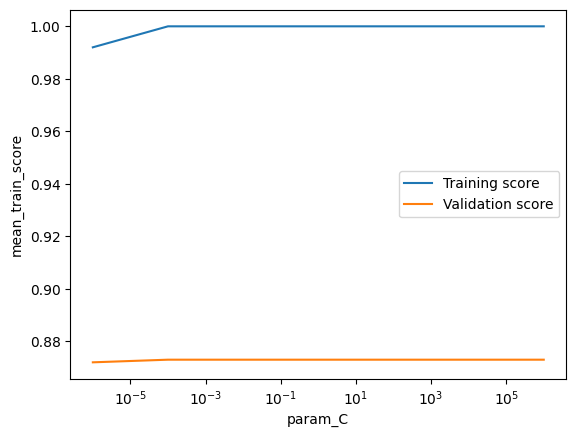

In [27]:
sns.lineplot(data=pd.DataFrame(clf.cv_results_), x='param_C', y='mean_train_score', label="Training score");
sns.lineplot(data=pd.DataFrame(clf.cv_results_), x='param_C', y='mean_test_score', label="Validation score");
plt.xscale('log');

It looks like we get a slightly better validation score near the smaller values for $C$! What does this mean?

Let’s try:

In [28]:
param_grid = [
  {'C': np.linspace(1e-5, 1e-7, num=10), 'kernel': ['linear']},
 ]
param_grid

[{'C': array([1.0e-05, 8.9e-06, 7.8e-06, 6.7e-06, 5.6e-06, 4.5e-06, 3.4e-06,
         2.3e-06, 1.2e-06, 1.0e-07]),
  'kernel': ['linear']}]

In [29]:
clf = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=100, n_jobs=-1, return_train_score=True)
%time clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 288 ms, sys: 21.5 ms, total: 310 ms
Wall time: 7.49 s


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': array([1.0e-05, 8.9e-06, 7.8e-06, 6.7e-06, 5.6e-06, 4.5e-06, 3.4e-06,
       2.3e-06, 1.2e-06, 1.0e-07]),
                          'kernel': ['linear']}],
             return_train_score=True, verbose=100)

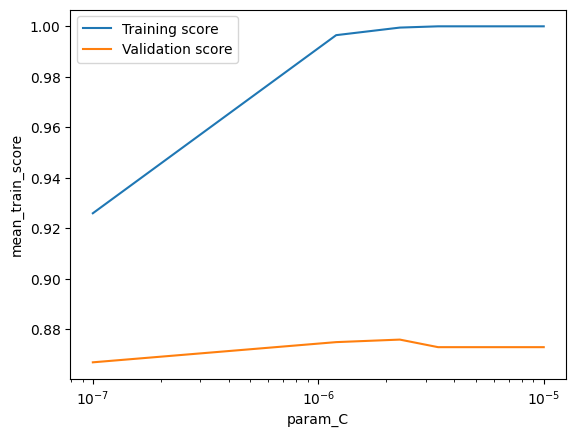

In [30]:
sns.lineplot(data=pd.DataFrame(clf.cv_results_), x='param_C', y='mean_train_score', label="Training score");
sns.lineplot(data=pd.DataFrame(clf.cv_results_), x='param_C', y='mean_test_score', label="Validation score");
plt.xscale('log');

We can be satisfied that we have found a good hyperparameter only when we see the high bias AND high variance side of the validation curve!

### RBF kernel

Now, let’s look at the RBF kernel.

In our first search, the accuracy of the RBF kernel is very poor. We may have high bias, high variance, (or both).

When $C=0.1$ in our first search, both training and validation scores were low. This suggests high bias.

When $C=1000$ in our first search, training scores were high and validation scores were low. This suggests high variance.

What next? We know from our discussion of bias and variance of SVMs that to combat overfitting, we can decrease $\gamma$ and/or decrease $C$.

For now, let’s keep the higher value of $C$, and try to reduce the overfitting by decreasing $\gamma$.

In [31]:
param_grid = [
  {'C': [1000], 'gamma': [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11], 'kernel': ['rbf']},
 ]
param_grid

[{'C': [1000],
  'gamma': [0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11],
  'kernel': ['rbf']}]

In [32]:
clf = GridSearchCV(SVC(), param_grid, cv=2, refit=True, verbose=100, n_jobs=-1, return_train_score=True)
%time clf.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
CPU times: user 276 ms, sys: 8.66 ms, total: 284 ms
Wall time: 6.08 s


GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1000],
                          'gamma': [0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09,
                                    1e-10, 1e-11],
                          'kernel': ['rbf']}],
             return_train_score=True, verbose=100)

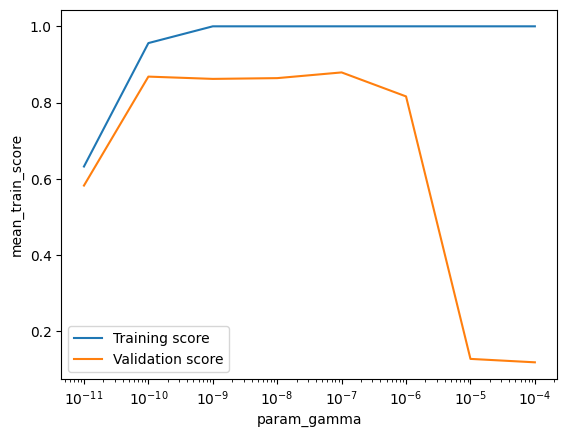

In [33]:
sns.lineplot(data=pd.DataFrame(clf.cv_results_), x='param_gamma', y='mean_train_score', label="Training score")
sns.lineplot(data=pd.DataFrame(clf.cv_results_), x='param_gamma', y='mean_test_score', label="Validation score")
plt.xscale('log');

Here, we see that (at least for $C=1000$), values of $\gamma$ greater than `1e-5` seem to overfit, while decreasing $\gamma$ lower than `1e-10` may underfit.

But we know that changing $C$ also affects the bias variance tradeoff! For different values of $C$, the best value of $\gamma$ will be different, and there may be a better *combination* of $C$ and $\gamma$ than any we have seen so far. We can try to increase and decrease $C$ to see if that improves the validation score.

Now that we have a better idea of where to search, we can set up our “final” search grid.

We know that to find the best validation accuracy for the linear kernel, we should make sure our search space includes `1e-6` and `1e-7`. I chose to vary $C$ from `1e-8` to `1e-4`. (I want to make sure the best value is not at the edge of the search space, so that we can be sure there isn’t a better value if we go lower/higher.)

We know that to find the best validation accuracy for the RBF kernel, we should make sure our search space includes $\gamma$ values around `1e-6` and `1e-7` when $C=1000$. For larger values of $C$, we expect that we’ll get better results with smaller values of $\gamma$. For smaller values of $C$, we expect that we’ll get better results with larger values of $\gamma$. I chose to vary $C$ from `1` to `1e6` and $\gamma$ from `1e-4` to `1e-11`.

That’s a big search grid, so this takes a long time to fit! (Try this at home with a larger training set to get an idea...)

In [34]:
param_grid = [
  {'C': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4], 'kernel': ['linear']},
  {'C': [1, 1e2, 1e3, 1e4, 1e5, 1e6], 'gamma': [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11], 'kernel': ['rbf']},
 ]
param_grid

[{'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001], 'kernel': ['linear']},
 {'C': [1, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
  'gamma': [0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11],
  'kernel': ['rbf']}]

In [35]:
clf = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=100, n_jobs=-1, return_train_score=True)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 53 candidates, totalling 159 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001],
                          'kernel': ['linear']},
                         {'C': [1, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
                          'gamma': [0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09,
                                    1e-10, 1e-11],
                          'kernel': ['rbf']}],
             return_train_score=True, verbose=100)

For the linear kernel, here's what we found:

In [36]:
df_cv   = pd.DataFrame(clf.cv_results_)
df_cv = df_cv[df_cv['param_kernel']=='linear']

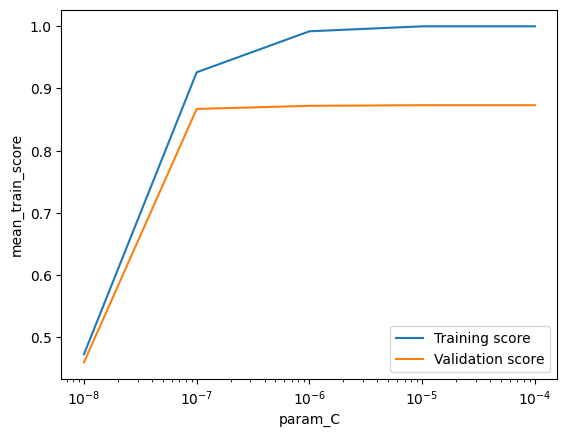

In [37]:
sns.lineplot(data=df_cv, x='param_C', y='mean_train_score', label="Training score")
sns.lineplot(data=df_cv, x='param_C', y='mean_test_score', label="Validation score")
plt.xscale('log');

For the RBF kernel, here's what we found:

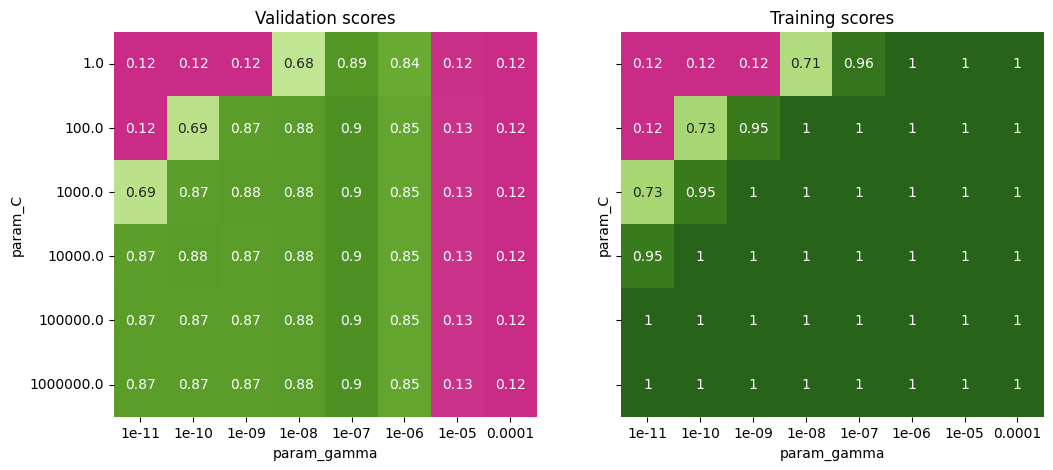

In [38]:
df_cv   = pd.DataFrame(clf.cv_results_)
df_cv = df_cv[df_cv['param_kernel']=='rbf']

plt.figure(figsize=(12,5))

ax1=plt.subplot(1,2,1)
pvt = pd.pivot_table(df_cv, values='mean_test_score', index='param_C', columns='param_gamma')
sns.heatmap(pvt, annot=True, cbar=False, vmin=0, vmax=1, cmap='PiYG');
plt.title("Validation scores");

ax2=plt.subplot(1,2,2, sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
pvt = pd.pivot_table(df_cv, values='mean_train_score', index='param_C', columns='param_gamma')
sns.heatmap(pvt, annot=True, cbar=False, vmin=0, vmax=1, cmap='PiYG');
plt.title("Training scores");

We see that $\gamma$ and $C$ control the bias-variance tradeoff of the SVM model as follows.

-   In the top left region, $C$ is small (the margin is wider) and $\gamma$ is small (the kernel bandwidth is large). In this region, the model has more bias (is prone to underfit). The validation scores and training scores are both low.
-   On the right side (and we'd expect to see this on the bottom right if we extend the range of $C$ even higher), $C$ is large (the margin is narrower) and $\gamma$ is large (the kernel bandwidth is small. In this region, the model has more variance (is likely to overfit). The validation scores are low, but the training scores are high.

In the middle, we have a region of good combinations of $C$ and $\gamma$.

Since the parameter grid above shows us the validation accuracy decreasing both as we increase each parameter\* and also as we decrease each parameter, we can be a bit more confident that we captured the point in the bias-variance surface where the error is smallest.

\* $C$ is different because increasing $C$ even more may not actually change the margin.

We can see the “best” parameters, with which the model was re-fitted:

In [39]:
print(clf.best_params_)

{'C': 100.0, 'gamma': 1e-07, 'kernel': 'rbf'}


And we can evaluate the re-fitted model on the test set. (Note that the `GridSearchCV` only used the training set; we have not used the test set at all for model fitting.)

In [40]:
y_pred = clf.predict(X_test)

In [41]:
accuracy_score(y_pred, y_test)

0.94